# Knee Arthritis Detection Using CNNs
This notebook provides a comprehensive analysis for knee arthritis detection using deep learning. The project includes:
- Complete Exploratory Data Analysis (EDA)
- Class imbalance handling techniques
- CNN model with detailed architecture explanation
- Model evaluation and visualization

In [1]:
# Essential imports
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tqdm import tqdm
import hashlib
import tensorflow as tf
# from google.colab import files

# Keras 3 imports
import keras
from keras import layers, models, optimizers, callbacks, utils
from keras.applications import efficientnet

# Scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report, f1_score

# Set random seeds for reproducibility
SEED_NUMBER = 1207
tf.random.set_seed(SEED_NUMBER)
np.random.seed(SEED_NUMBER)
random.seed(SEED_NUMBER)

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print(f"Libraries loaded!")
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")

2025-07-12 20:24:04.227015: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-12 20:24:04.243681: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752369844.260243   67664 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752369844.265572   67664 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752369844.283531   67664 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Libraries loaded!
TensorFlow version: 2.19.0
Keras version: 3.10.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Data Loading and Initial Exploration

In [2]:
# Uncomment this when working in COLAB
# uploaded = files.upload()

#for fn in uploaded.keys():
#  print('User uploaded file "{name}" with length {length} bytes'.format(
#      name=fn, length=len(uploaded[fn])))

!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

mv: cannot stat 'kaggle.json': No such file or directory


In [3]:
# ! kaggle datasets download hafiznouman786/annotated-dataset-for-knee-arthritis-detection -p /content/knee-arthritis-detection --unzip
! kaggle datasets download hafiznouman786/annotated-dataset-for-knee-arthritis-detection -p ./data/knee-arthritis-detection --unzip

Dataset URL: https://www.kaggle.com/datasets/hafiznouman786/annotated-dataset-for-knee-arthritis-detection
License(s): CC0-1.0
  0%|                                               | 0.00/58.3M [00:00<?, ?B/s]
100%|██████████████████████████████████████| 58.3M/58.3M [00:00<00:00, 1.07GB/s]


In [4]:
# Helper Functions for Data Loading
def get_image_paths(dataset_dir):
    """Collects image paths and extracts labels from the folder structure."""
    records = []
    if not os.path.exists(dataset_dir):
        print(f"Error: Dataset directory not found at '{dataset_dir}'")
        return pd.DataFrame(records), {}

    folders = sorted([f for f in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, f))])
    label_to_id = {folder: idx for idx, folder in enumerate(folders)}

    for folder in folders:
        folder_path = os.path.join(dataset_dir, folder)
        for fname in os.listdir(folder_path):
            if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                records.append({
                    'filepath': os.path.join(folder_path, fname),
                    'label_id': label_to_id[folder],
                    'label_name': folder
                })
    return pd.DataFrame(records), label_to_id

In [5]:
# IMPORTANT: Update this path to where your Training dataset is located in Google Drive.
# dataset_path = '/content/knee-arthritis-detection/Training'
dataset_path = './data/knee-arthritis-detection/Training'
df, label_mapping = get_image_paths(dataset_path)

if df.empty:
  raise ValueError("No images found in the dataset directory.")

print(f"\nDataset loaded successfully!")
print(f"Total images: {len(df)}")
print(f"Classes found: {list(label_mapping.keys())}")
print(f"Label mapping: {label_mapping}")


Dataset loaded successfully!
Total images: 1650
Classes found: ['0Normal', '1Doubtful', '2Mild', '3Moderate', '4Severe']
Label mapping: {'0Normal': 0, '1Doubtful': 1, '2Mild': 2, '3Moderate': 3, '4Severe': 4}


## Comprehensive EDA

In [6]:
def analyze_class_distribution(df):
    """Analyzes and visualizes the class distribution."""
    print("DETAILED CLASS DISTRIBUTION ANALYSIS")

    class_counts = df['label_name'].value_counts()
    total_samples = len(df)

    # Calculate imbalance ratio
    max_class = class_counts.max()
    imbalance_ratios = max_class / class_counts

    print("\nClass Statistics:")
    for class_name, count in class_counts.items():
        percentage = (count / total_samples) * 100
        imbalance_ratio = imbalance_ratios[class_name]
        print(f"{class_name}: {count} samples ({percentage:.1f}%) - Imbalance Ratio: {imbalance_ratio:.2f}")

    # Visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Bar plot
    sns.barplot(x=class_counts.index, y=class_counts.values, ax=axes[0,0], palette='viridis', hue=imbalance_ratios.index)
    axes[0,0].set_title('Image Count by Arthritis Stage', fontweight='bold')
    axes[0,0].set_ylabel('Number of Images')
    axes[0,0].tick_params(axis='x', rotation=45)

    # Pie chart
    axes[0,1].pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%',
                  startangle=90, colors=sns.color_palette('husl', len(class_counts)))
    axes[0,1].set_title('Class Distribution Percentage', fontweight='bold')

    # Imbalance ratio plot
    sns.barplot(x=imbalance_ratios.index, y=imbalance_ratios.values, ax=axes[1,0], palette='Reds', hue=imbalance_ratios.index)
    axes[1,0].set_title('Class Imbalance Ratios', fontweight='bold')
    axes[1,0].set_ylabel('Imbalance Ratio')
    axes[1,0].tick_params(axis='x', rotation=45)
    axes[1,0].axhline(y=1, color='black', linestyle='--', alpha=0.7)

    axes[1, 1].axis('off')

    plt.tight_layout()
    plt.show()

    return class_counts, imbalance_ratios

DETAILED CLASS DISTRIBUTION ANALYSIS

Class Statistics:
0Normal: 514 samples (31.2%) - Imbalance Ratio: 1.00
1Doubtful: 477 samples (28.9%) - Imbalance Ratio: 1.08
2Mild: 232 samples (14.1%) - Imbalance Ratio: 2.22
3Moderate: 221 samples (13.4%) - Imbalance Ratio: 2.33
4Severe: 206 samples (12.5%) - Imbalance Ratio: 2.50


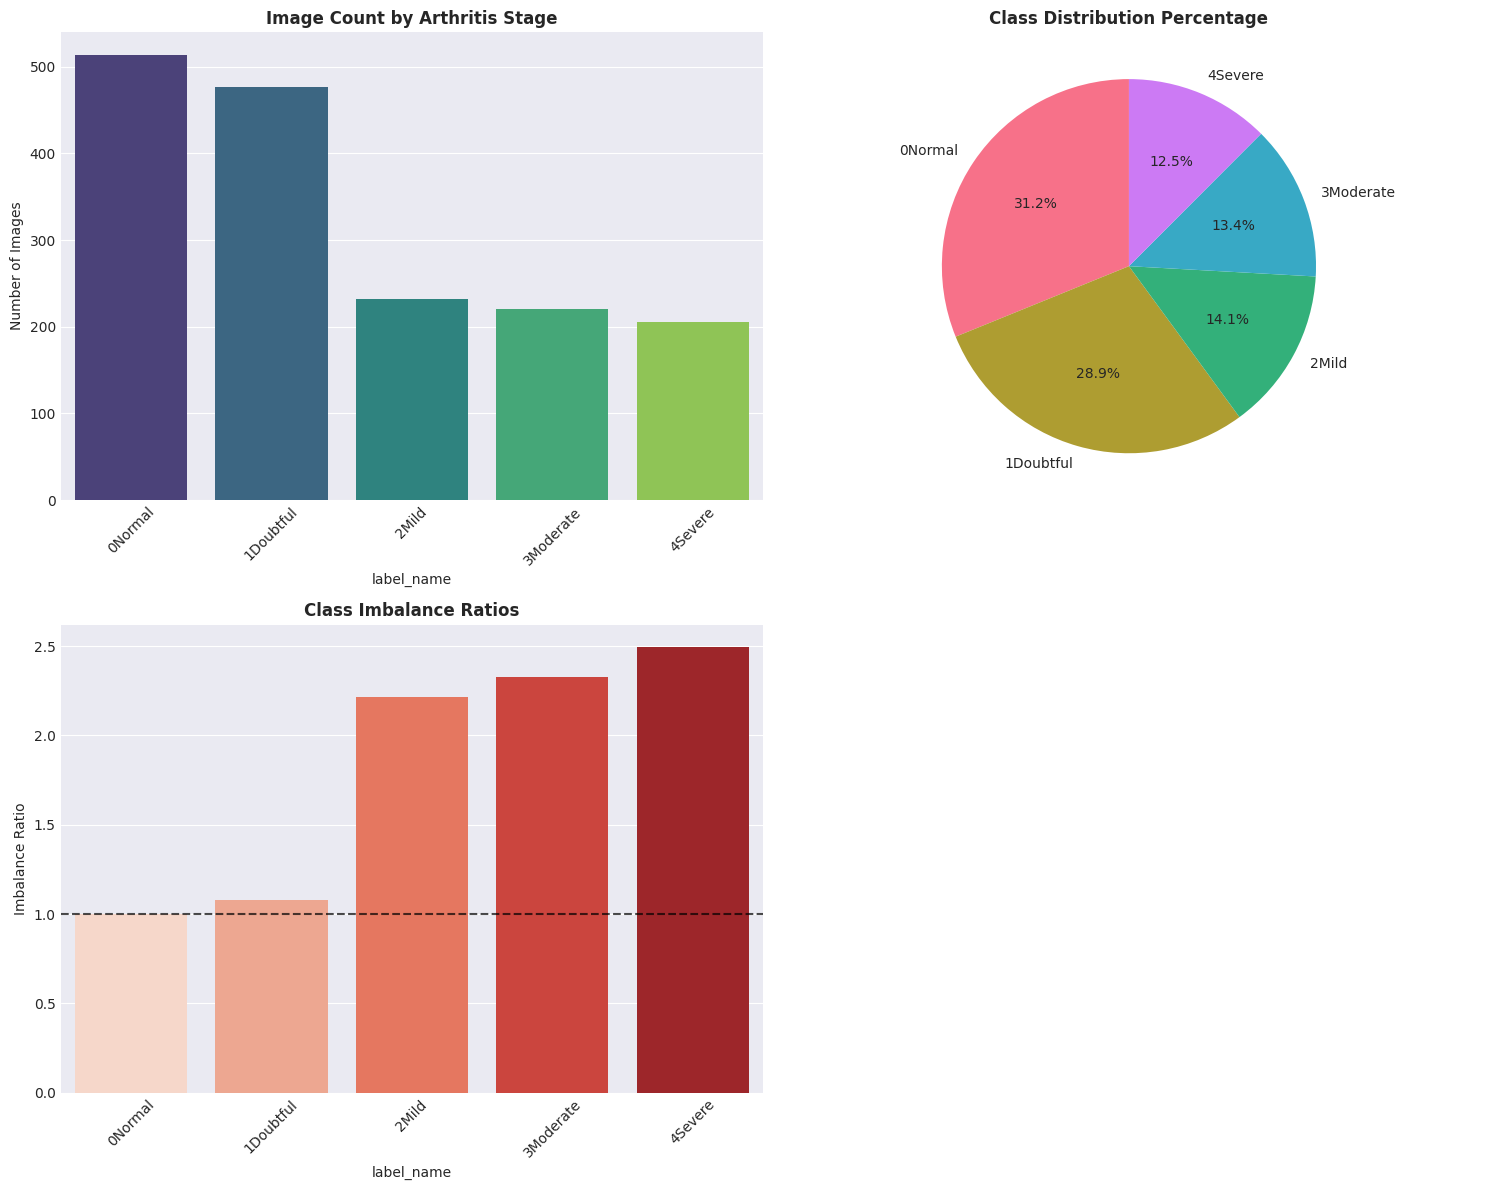

(label_name
 0Normal      514
 1Doubtful    477
 2Mild        232
 3Moderate    221
 4Severe      206
 Name: count, dtype: int64,
 label_name
 0Normal      1.000000
 1Doubtful    1.077568
 2Mild        2.215517
 3Moderate    2.325792
 4Severe      2.495146
 Name: count, dtype: float64)

In [7]:
analyze_class_distribution(df)

## Data Preprocessing & Splitting

In [8]:
def remove_duplicates(dataframe):
    """
    Removes duplicate images from a dataframe by hashing image files.
    """
    hashes = set()
    duplicates = []

    for idx, row in tqdm(dataframe.iterrows(), total=len(dataframe), desc="Hashing images"):
        filepath = row['filepath']
        try:
            with open(filepath, 'rb') as f:
                file_hash = hashlib.md5(f.read()).hexdigest()

            if file_hash in hashes:
                duplicates.append(idx)
            else:
                hashes.add(file_hash)
        except Exception as e:
            print(f"Could not process {filepath}: {e}")
            duplicates.append(idx) # Mark for removal if unreadable

    if duplicates:
        print(f"Found and removed {len(duplicates)} duplicate/unreadable images.")
        dataframe = dataframe.drop(index=duplicates).reset_index(drop=True)
    else:
        print("No duplicate images found.")

    return dataframe

In [9]:
def load_and_preprocess_image(filepath, img_size):
    """Loads and preprocesses a single image."""
    # Load image in grayscale
    img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    if img is None: return None

    # Resize with a high-quality interpolation method
    img = cv2.resize(img, (img_size, img_size), interpolation=cv2.INTER_LANCZOS4)

    # CLAHE for contrast enhancement (good for medical images)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img = clahe.apply(img)

    # Convert to 3 channels for the pre-trained model
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    
    # Return image with pixel values in [0, 255]
    return img.astype(np.uint8)

In [10]:
def create_dataset(df, img_size):
    """Loads and preprocesses all images from the dataframe."""
    X, y = [], []
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Processing Images"):
        img = load_and_preprocess_image(row['filepath'], img_size)
        if img is not None:
            X.append(img)
            y.append(row['label_id'])
    return np.array(X), np.array(y)

In [11]:
# Remove Duplicates
df_cleaned = remove_duplicates(df)
print(f"Dataset size after duplicate removal: {len(df_cleaned)} images.")

# Load, Resize, and Preprocess Images
IMG_SIZE = 224
X, y = create_dataset(df_cleaned, IMG_SIZE)

print("\nSplitting data...")
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=SEED_NUMBER)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.15, stratify=y_train_val, random_state=SEED_NUMBER)
print(f"Training: {len(X_train)}, Validation: {len(X_val)}, Test: {len(X_test)}")

# We will handle class imbalance using a combination of data augmentation
# layers and class weights in model.fit()
print(f"Original training distribution: {np.bincount(y_train)}")

# Preprocess inputs for EfficientNet
# This step correctly scales pixels and prepares them for the model [0-1]
# A copy is made to avoid modifying the original data
X_train_processed = efficientnet.preprocess_input(X_train.copy())
X_val_processed = efficientnet.preprocess_input(X_val.copy())
X_test_processed = efficientnet.preprocess_input(X_test.copy())

# Convert labels to one-hot encoding
num_classes = len(label_mapping)
y_train_cat = utils.to_categorical(y_train, num_classes=num_classes)
y_val_cat = utils.to_categorical(y_val, num_classes=num_classes)
y_test_cat = utils.to_categorical(y_test, num_classes=num_classes)

print(f"\nData shapes:")
print(f"X_train_processed: {X_train_processed.shape}, y_train_cat: {y_train_cat.shape}")
print(f"X_val_processed: {X_val_processed.shape},   y_val_cat: {y_val_cat.shape}")
print(f"X_test_processed: {X_test_processed.shape},  y_test_cat: {y_test_cat.shape}")

Hashing images: 100%|██████████| 1650/1650 [00:00<00:00, 13389.18it/s]


Found and removed 17 duplicate/unreadable images.
Dataset size after duplicate removal: 1633 images.


Processing Images: 100%|██████████| 1633/1633 [00:02<00:00, 766.48it/s]



Splitting data...
Training: 1179, Validation: 209, Test: 245
Original training distribution: [370 342 164 154 149]

Data shapes:
X_train_processed: (1179, 224, 224, 3), y_train_cat: (1179, 5)
X_val_processed: (209, 224, 224, 3),   y_val_cat: (209, 5)
X_test_processed: (245, 224, 224, 3),  y_test_cat: (245, 5)


## Model Building & Training

In [12]:
def build_cnn_model(input_shape, num_classes):
    """
    Builds a CNN model using the Keras Functional API with integrated data augmentation.
    """
    inputs = keras.Input(shape=input_shape)

    # Data Augmentation Layers
    x = layers.RandomFlip("horizontal")(inputs)
    x = layers.RandomRotation(0.1)(x)
    x = layers.RandomZoom(0.1)(x)
    x = layers.RandomContrast(0.1)(x)

    # Simplified and more standard architecture
    # Block 1
    x = layers.Conv2D(32, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.2)(x)

    # Block 2
    x = layers.Conv2D(64, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.2)(x)

    # Block 3
    x = layers.Conv2D(128, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)

    # Classification Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [13]:
# Model Building with Transfer Learning
def build_transfer_model(input_shape, num_classes):
    """
    Builds a model using EfficientNetB0 as a base with fine-tuning enabled
    on the top layers from the start.
    """
    # Define the input layer
    inputs = keras.Input(shape=input_shape)

    # Add data augmentation layers
    x = layers.RandomFlip("horizontal")(inputs)
    x = layers.RandomRotation(0.1)(x)
    x = layers.RandomZoom(0.2)(x)
    x = layers.RandomContrast(0.1)(x)

    # Load the pre-trained base model
    # The augmentation layers are applied before the base model sees the images.
    base_model = efficientnet.EfficientNetB0(include_top=False, weights='imagenet', input_tensor=x)

    # Freeze the entire base model initially
    base_model.trainable = False

    # Unfreeze the top layers for fine-tuning
    # This is a common and effective strategy.
    for layer in base_model.layers[-25:]:
        if hasattr(layer, 'trainable'):
            layer.trainable = True

    # Add our custom classification head
    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.BatchNormalization()(x) # Add Batch Norm for stability
    x = layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


In [14]:
## Common variables
BATCH_SIZE = 16
LEARNING_RATE = 1e-4
MODEL_METRICS = ['accuracy'] # ['accuracy', 'f1_score', 'recall', 'precision']
# Class Weighting for Imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
print(f"\nCalculated class weights: {class_weights_dict}")


Calculated class weights: {0: np.float64(0.6372972972972973), 1: np.float64(0.6894736842105263), 2: np.float64(1.4378048780487804), 3: np.float64(1.5311688311688312), 4: np.float64(1.5825503355704698)}


### From Scratch

In [15]:
model = build_cnn_model((IMG_SIZE, IMG_SIZE, 3), num_classes)

# Compile
optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=MODEL_METRICS
)

model.summary()

I0000 00:00:1752369862.914528   67664 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast                 │ (None, 224, 224, 3)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,51

 Total params: 111,813 (436.77 KB)

 Trainable params: 111,109 (434.02 KB)

 Non-trainable params: 704 (2.75 KB)

In [16]:
EPOCHS = 100

# Callbacks
training_callbacks = [
    callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6),
    callbacks.ModelCheckpoint('best_knee_arthritis_model.keras', monitor='val_loss', save_best_only=True)
]
print("\nStarting model training...")
history = model.fit(
    X_train, y_train_cat,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val_cat),
    callbacks=training_callbacks,
    class_weight=class_weights_dict
)
print("\nTraining complete!")


Starting model training...
Epoch 1/100


E0000 00:00:1752369865.864759   67664 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1752369867.020167   67806 cuda_dnn.cc:529] Loaded cuDNN version 90300


74/74 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - accuracy: 0.2404 - loss: 1.8438 - val_accuracy: 0.3062 - val_loss: 1.6741 - learning_rate: 1.0000e-04
Epoch 2/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 0.2827 - loss: 1.6617 - val_accuracy: 0.3110 - val_loss: 1.5682 - learning_rate: 1.0000e-04
Epoch 3/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 0.2991 - loss: 1.6514 - val_accuracy: 0.3876 - val_loss: 1.4615 - learning_rate: 1.0000e-04
Epoch 4/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 0.2889 - loss: 1.6969 - val_accuracy: 0.3493 - val_loss: 1.4702 - learning_rate: 1.0000e-04
Epoch 5/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - accuracy: 0.2976 - loss: 1.6553 - val_accuracy: 0.3828 - val_loss: 1.5093 - learning_rate: 1.0000e-04
Epoch 6/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - accuracy: 0.3154 - loss: 1.6958 - val_accuracy: 0.3062 - val_loss: 1.5702 - learning_rate: 1.0000e-04
Epoch 7/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.3048 - lo

### Using Efficientnetb0

The primary model is a transfer learning model built on **`EfficientNetB0`**:

1.  **Input Layer:** Accepts `(224, 224, 3)` images.
2.  **Data Augmentation:** Keras layers for `RandomFlip`, `RandomRotation`, and `RandomZoom` are integrated directly into the model to augment data.
3.  **Base Model:** An `EfficientNetB0` base, with its ImageNet weights. The top layers of the base model are unfrozen and made trainable for fine-tuning on the dataset.
4.  **Classification Head:** A custom head is added on top of the base model, consisting of:
      * A `GlobalAveragePooling2D` layer to reduce spatial dimensions.
      * A `BatchNormalization` layer for stability.
      * A `Dense` layer with 512 units and ReLU activation.
      * A `Dropout` layer for regularization.
      * A final `Dense` output layer with 5 units and a `softmax` activation for multi-class classification.

In [17]:
# Compile
model = build_transfer_model((IMG_SIZE, IMG_SIZE, 3), num_classes)
optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=MODEL_METRICS
)

model.summary(expand_nested=False)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_flip_1       │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (RandomFlip)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_rotation_1   │ (None, 224, 224,  │          0 │ random_flip_1[0]… │
│ (RandomRotation)    │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_zoom_1       │ (None, 224, 224,  │          0 │ random_rotation_… │
│ (RandomZoom)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_contrast_1   │ (None, 224, 224,  │          0 │ random_zoom_1[0]… │
│ (RandomContrast)    │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ random_contrast_… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee

 Total params: 4,713,128 (17.98 MB)

 Trainable params: 2,123,749 (8.10 MB)

 Non-trainable params: 2,589,379 (9.88 MB)

In [18]:
training_callbacks = [
    callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=1e-6, verbose=1),
    callbacks.ModelCheckpoint('best_arthritis_finetuned.keras', monitor='val_loss', save_best_only=True)
]

print("\nStarting model training...")

history = model.fit(
    X_train_processed, y_train_cat,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val_processed, y_val_cat),
    callbacks=training_callbacks,
    class_weight=class_weights_dict
)

print("\nTraining complete!")


Starting model training...
Epoch 1/100


E0000 00:00:1752369968.278805   67664 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


74/74 ━━━━━━━━━━━━━━━━━━━━ 14s 97ms/step - accuracy: 0.2448 - loss: 2.9035 - val_accuracy: 0.4019 - val_loss: 2.0780 - learning_rate: 1.0000e-04
Epoch 2/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.4453 - loss: 2.2246 - val_accuracy: 0.5694 - val_loss: 1.8132 - learning_rate: 1.0000e-04
Epoch 3/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 0.5266 - loss: 2.0589 - val_accuracy: 0.6507 - val_loss: 1.6621 - learning_rate: 1.0000e-04
Epoch 4/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.5572 - loss: 1.8887 - val_accuracy: 0.6507 - val_loss: 1.5764 - learning_rate: 1.0000e-04
Epoch 5/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - accuracy: 0.5855 - loss: 1.8683 - val_accuracy: 0.6890 - val_loss: 1.4919 - learning_rate: 1.0000e-04
Epoch 6/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - accuracy: 0.5939 - loss: 1.7972 - val_accuracy: 0.6890 - val_loss: 1.4660 - learning_rate: 1.0000e-04
Epoch 7/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.6102 - lo

## Evaluation and Visualization

In [19]:
def plot_training_history(history):
    """Visualizes the model's training and validation history."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Loss plot
    axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
    axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    axes[0].set_title('Training and Validation Loss', fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Accuracy plot
    axes[1].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    axes[1].set_title('Training and Validation Accuracy', fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

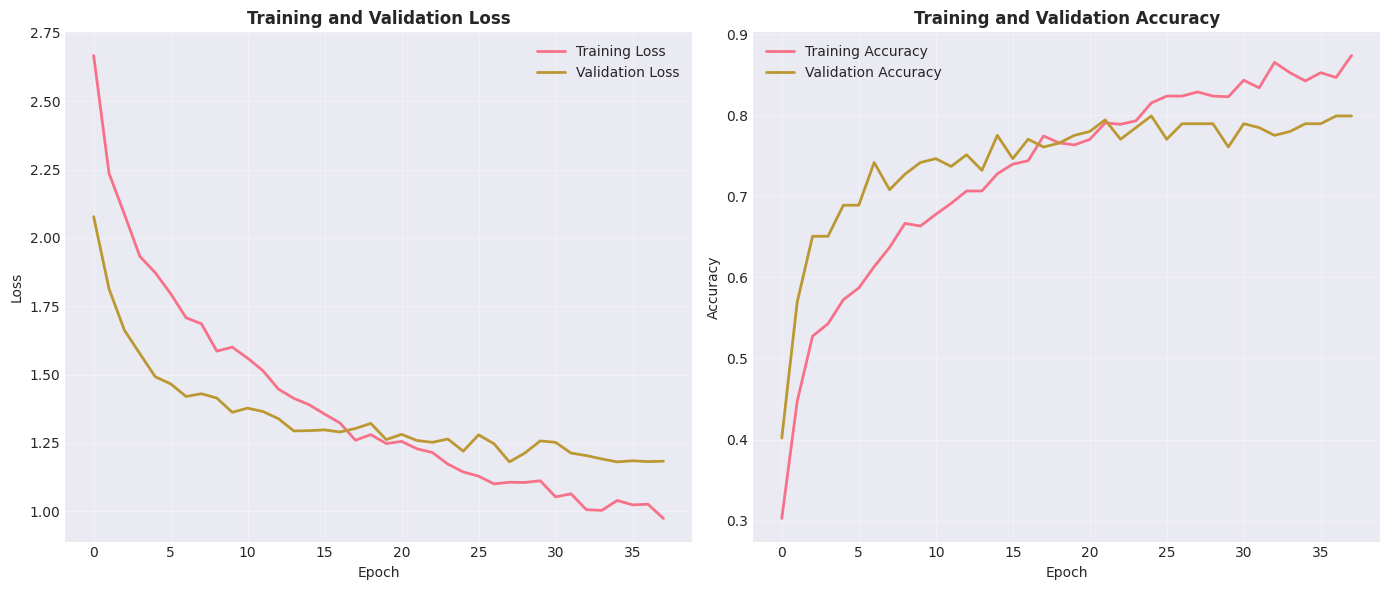


 !!!! FINAL MODEL EVALUATION !!!!

Test Accuracy: 77.14%
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 169ms/step

Classification Report:
              precision    recall  f1-score   support

     0Normal       0.84      0.91      0.88        77
   1Doubtful       0.69      0.63      0.66        71
       2Mild       0.59      0.65      0.62        34
   3Moderate       0.87      0.84      0.86        32
     4Severe       0.86      0.81      0.83        31

    accuracy                           0.77       245
   macro avg       0.77      0.77      0.77       245
weighted avg       0.77      0.77      0.77       245



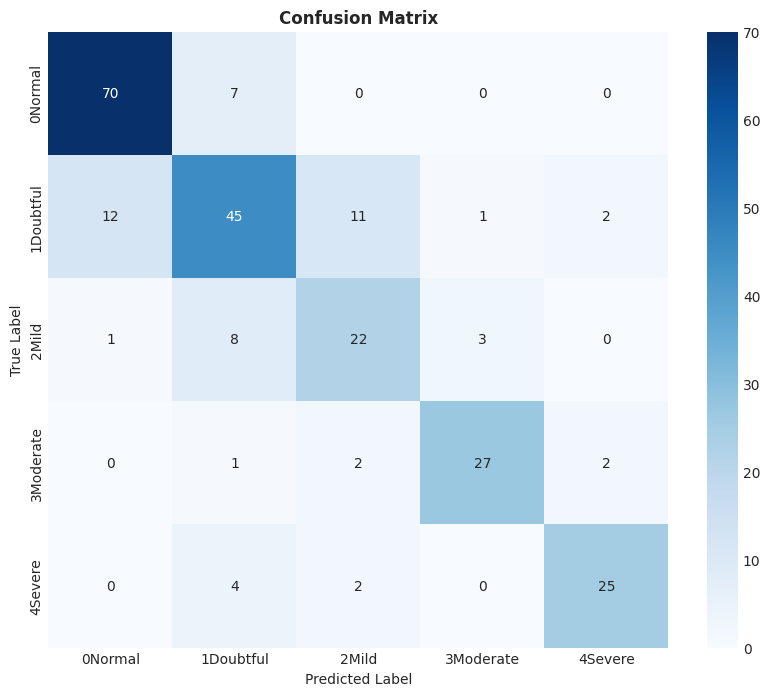

In [20]:
plot_training_history(history)

print("\n !!!! FINAL MODEL EVALUATION !!!!")

# best_model = models.load_model('best_knee_arthritis_model.keras')
best_model = models.load_model('best_arthritis_finetuned.keras')
test_loss, test_accuracy = best_model.evaluate(X_test, y_test_cat, verbose=0)
print(f"\nTest Accuracy: {test_accuracy*100:.2f}%")

y_pred_probs = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

id_to_label = {v: k for k, v in label_mapping.items()}
class_names = [id_to_label[i] for i in range(num_classes)]

print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix', fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()